In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.models.pipelines.sdes_samplers.samplers import TauLeaping
from conditional_rate_matching import results_path
from torchvision.utils import make_grid

from conditional_rate_matching.configs.experiments_configs.crm.crm_experiments_Cifar import experiment_cifar10_config
from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat_config import (ConstantThermostatConfig, 
                                                                                         PeriodicThermostatConfig,
                                                                                         ExponentialThermostatConfig,
                                                                                         PolynomialThermostatConfig,
                                                                                         PlateauThermostatConfig
                                                                                         )

def generate_samples(trained_model, 
                     x_test,
                     num_timesteps=100, 
                     time_epsilon=0.0,
                     device="cpu"):
    
    experiment_dir = os.path.join(results_path,"crm", trained_model)
    crm = CRM(experiment_dir=experiment_dir, device=device)
    crm.config.pipeline.time_epsilon = time_epsilon
    crm.config.pipeline.num_intermediates = num_timesteps
    crm.config.pipeline.number_of_steps = num_timesteps

    x_1, x_t, t = crm.pipeline(x_test.shape[0], 
                               return_intermediaries=True, 
                               train=False, 
                               x_0=x_test)
    
    x_1 = x_1.view(-1, 3, 32, 32)
    x_t = x_t.view(-1, x_t.shape[1], 3, 32, 32)
    return x_1, x_t, t

def cifar_noise_bridge(path, 
                       x_input, 
                       num_timesteps=1000,  
                       time_epsilon=0.0,
                       num_img=5,
                       num_timesteps_displayed=20,
                       save_path=None):
    
    img_1, img_hist, time_steps = generate_samples(path, x_input[:num_img], num_timesteps=num_timesteps,  time_epsilon=time_epsilon, device=x_input.device)
    _, axs = plt.subplots(num_img, num_timesteps_displayed+2, figsize=(num_timesteps_displayed, num_img))
    N = img_hist.size(1)
    dt = N // num_timesteps_displayed

    img_1 = img_1.long()  # Normalize to [0, 1] if necessary
    img_hist = img_hist.long() # Normalize to [0, 1] if necessary

    for j, idx in enumerate(np.arange(0, N+1, dt)):
        if j<num_timesteps_displayed:
            tau = time_steps[idx]
            images = img_hist[:, idx, :]
        else:
            tau = time_steps[-1]
            images = img_hist[:, -1, :]
            
        for i in range(num_img):
            img = images[i].detach().cpu().numpy()
            axs[i, j].imshow(img.squeeze().transpose(1, 2, 0) , cmap='gray')
            if i == 0: axs[i, j].set_title(r'$\tau = {0}$'.format(round(tau.item(),2)))
            axs[i, j].axis('off')
    
    j = num_timesteps_displayed + 1
    for i in range(num_img):
        axs[i, j].imshow(img_1[i].detach().cpu().numpy().squeeze().transpose(1, 2, 0) , cmap='gray')
        axs[i, j].axis('off')

    plt.tight_layout()
    if save_path is None: plt.show()
    else: plt.savefig(save_path+'/bridge_example.png')

def cifar_conditional_bridge(source, 
                             target, 
                             thermostat="constant", 
                             thermostat_params=(.1,0),
                             figsize=None, 
                             num_timesteps=100,
                             num_timesteps_displayed=10,
                             save_path=None):
    
    config = experiment_cifar10_config()
    
    if thermostat == 'exponential':
        config.thermostat = ExponentialThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
        config.thermostat.max = thermostat_params[1]
    elif thermostat == 'constant':
        config.thermostat = ConstantThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
    elif thermostat == 'periodic':
        config.thermostat = PeriodicThermostatConfig()
        config.thermostat.gamma= thermostat_params[0]
        config.thermostat.max = thermostat_params[1]
    elif thermostat == 'polynomial':
        config.thermostat = PolynomialThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
        config.thermostat.exponent = thermostat_params[1]
    elif thermostat == 'plateau':
        config.thermostat = PlateauThermostatConfig()
        config.thermostat.gamma = thermostat_params[0]
        config.thermostat.slope = thermostat_params[1]
        config.thermostat.shift = thermostat_params[2]

    crm = CRM(config)
    crm.config.pipeline.number_of_steps = num_timesteps
    crm.config.pipeline.num_intermediates = num_timesteps

    rate_model = lambda x, t: crm.forward_rate.conditional_transition_rate(x, target.view(-1, 3*32*32), t)
    img_1, img_hist, _, _ = TauLeaping(crm.config, rate_model, source.view(-1, 3*32*32), forward=True)

    N = img_hist.size(1)
    dt = N // num_timesteps_displayed

    num_img = source.shape[0]
    img_1 = img_1.long().view(-1, 3, 32, 32)
    img_hist = img_hist.long().view(-1, N, 3, 32, 32)
    _, axs = plt.subplots(num_img, num_timesteps_displayed+2, figsize=(num_timesteps_displayed, num_img) if figsize is None else figsize)

    for j, idx in enumerate(np.arange(0, N+1, dt)):
        if j < num_timesteps_displayed:
            images = img_hist[:, idx, :]
        else:
            images = img_hist[:, -1, :]
            
        for i in range(num_img):
            img = images[i].detach().cpu().numpy().transpose(1, 2, 0)  # Reorder dimensions to (height, width, channels)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
    
    j = num_timesteps_displayed + 1
    for i in range(num_img):
        axs[i, j].imshow(img_1[i].detach().cpu().numpy().transpose(1, 2, 0))  # Adjust this line similarly
        axs[i, j].axis('off')

    plt.tight_layout()
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path + '/conditional_markov_example.png')



def get_cifar10_test_samples(trained_model, 
                            which = 'source', # 'source' or 'target
                            class_label=None, 
                            sample_size=800, 
                            device="cpu"):
    
    experiment_dir = os.path.join(results_path,"crm", trained_model)
    crm = CRM(experiment_dir=experiment_dir, device=device)
    images = []
    source = crm.dataloader_0.test()
    target = crm.dataloader_1.test()

    for batch in source if which == 'source' else target:
        if len(batch) == 2:
            sample, labels = batch[0], batch[1]
            selected_images = sample[labels == class_label] if class_label is not None else sample 
            images.append(selected_images)
        else:
            sample = batch[0].view(-1, 3, 32, 32)
            images.append(sample)

    return torch.cat(images, dim=0)[:sample_size].to(device) #if labeled else torch.tensor(images, device=device)


def image_grid(sample, save_path='.', num_img=5, nrow=8, figsize=(10,10)):
    _, _= plt.subplots(1,1, figsize=figsize)
    sample = sample[:num_img]
    sample = sample / sample.max()
    img = make_grid(sample, nrow=nrow)
    npimg = np.transpose(img.detach().cpu().numpy(),(1,2,0))
    plt.imshow(npimg)
    plt.axis('off')
    plt.savefig(save_path+'/selected_sample.png')
    plt.show()

/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/tqdm-4.66.1-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EMNIST $\to$ MNIST

constant thermostat with: $\gamma=0.5$:

source data:

In [3]:
path = "crm_cifar10_gamma_0.01"
source_NOISE = get_cifar10_test_samples(path, which='source', sample_size=4, device="cuda:0")
image_grid(source_NOISE, nrow=4, num_img=3, figsize=(2,1))


ModuleNotFoundError: No module named 'diffusers.models.unets'

target data:

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


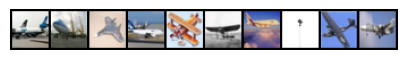

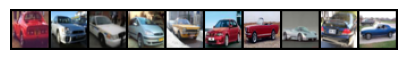

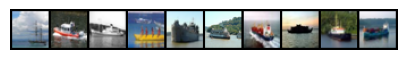

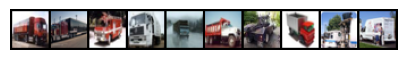

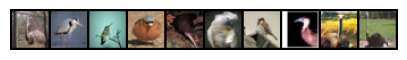

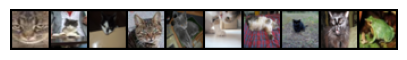

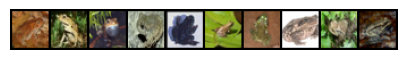

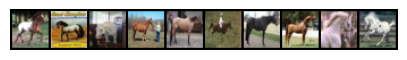

In [5]:
path = "crm_cifar10"
AIRPLANE = get_cifar10_test_samples(path, which='target', class_label=0, sample_size=10, device="cuda:0")
CAR = get_cifar10_test_samples(path, which='target', class_label=1, sample_size=10, device="cuda:0")
SHIP = get_cifar10_test_samples(path, which='target', class_label=8, sample_size=10, device="cuda:0")
TRUCK = get_cifar10_test_samples(path, which='target', class_label=9, sample_size=10, device="cuda:0")

BIRD = get_cifar10_test_samples(path, which='target', class_label=2, sample_size=10, device="cuda:0")
CAT = get_cifar10_test_samples(path, which='target', class_label=3, sample_size=10, device="cuda:0")
FROG = get_cifar10_test_samples(path, which='target', class_label=6, sample_size=10, device="cuda:0")
HORSE = get_cifar10_test_samples(path, which='target', class_label=7, sample_size=10, device="cuda:0")

image_grid(AIRPLANE, nrow=10, num_img=10, figsize=(5,5))
image_grid(CAR, nrow=10, num_img=10, figsize=(5,5))
image_grid(SHIP, nrow=10, num_img=10, figsize=(5,5))
image_grid(TRUCK, nrow=10, num_img=10, figsize=(5,5))

image_grid(BIRD, nrow=10, num_img=10, figsize=(5,5))
image_grid(CAT, nrow=10, num_img=10, figsize=(5,5))
image_grid(FROG, nrow=10, num_img=10, figsize=(5,5))
image_grid(HORSE, nrow=10, num_img=10, figsize=(5,5))

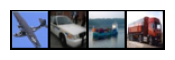

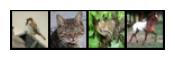

In [18]:

source_TRANSPORT = torch.cat([AIRPLANE[-2].unsqueeze(0), CAR[2].unsqueeze(0), SHIP[-1].unsqueeze(0), TRUCK[0].unsqueeze(0)], dim=0)  
image_grid(source_TRANSPORT, nrow=4, num_img=4, figsize=(2,1))

target_ANIMALS = torch.cat([BIRD[6].unsqueeze(0), CAT[3].unsqueeze(0), FROG[-2].unsqueeze(0), HORSE[0].unsqueeze(0)], dim=0)  
image_grid(target_ANIMALS, nrow=4, num_img=4, figsize=(2,1))

# Markov interpolators

Files already downloaded and verified
Files already downloaded and verified


100it [00:00, 199.89it/s]


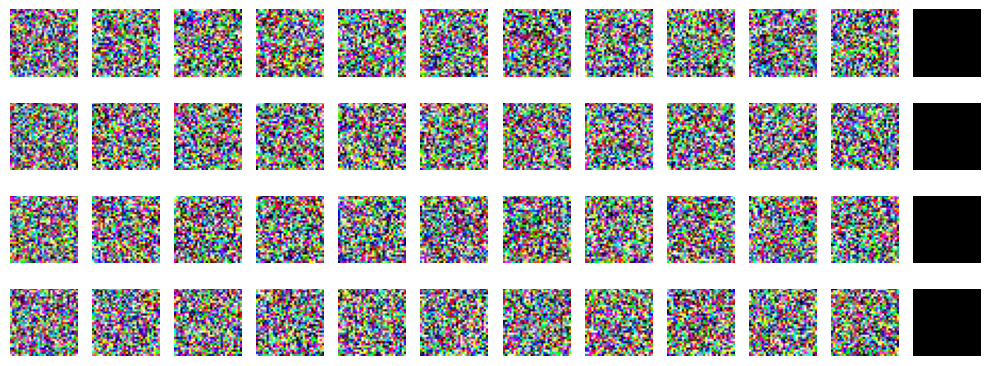

Files already downloaded and verified
Files already downloaded and verified


100it [00:00, 203.04it/s]


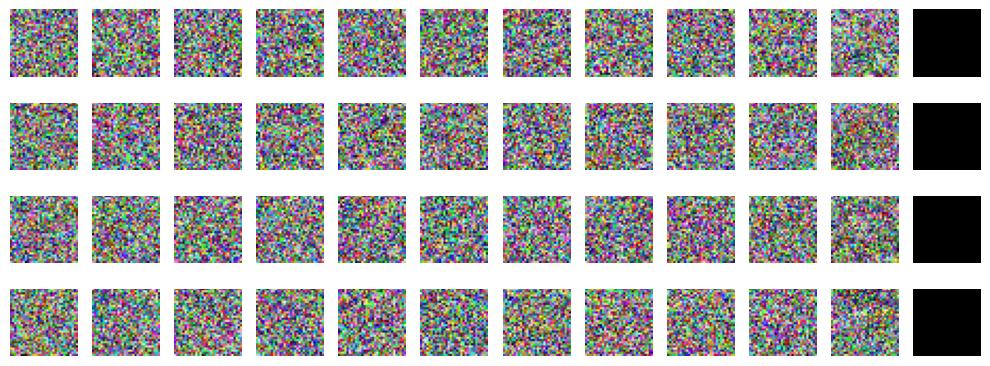

Files already downloaded and verified
Files already downloaded and verified


100it [00:00, 201.55it/s]


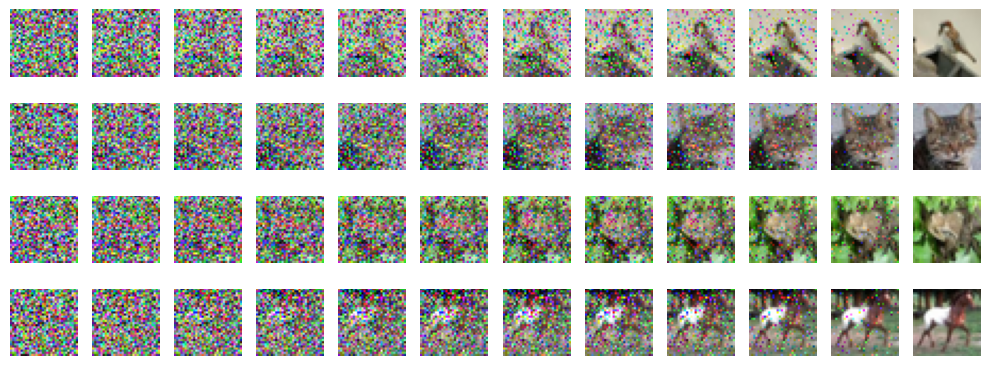

Files already downloaded and verified
Files already downloaded and verified


100it [00:00, 203.93it/s]


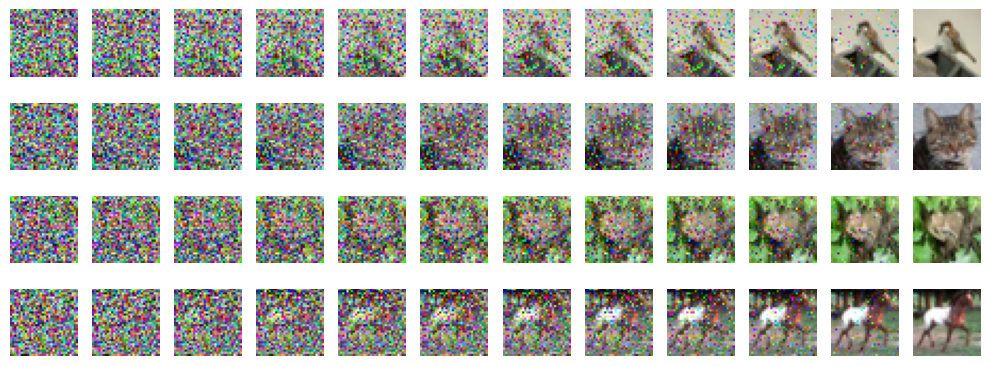

In [23]:
cifar_conditional_bridge(source_NOISE, target_ANIMALS, thermostat="constant", thermostat_params=(1.0, 0.0), num_timesteps=100, num_timesteps_displayed=10)
cifar_conditional_bridge(source_NOISE, target_ANIMALS, thermostat="constant", thermostat_params=(1e-1, 0.0), num_timesteps=100, num_timesteps_displayed=10)
cifar_conditional_bridge(source_NOISE, target_ANIMALS, thermostat="constant", thermostat_params=(1e-3, 0.0), num_timesteps=100, num_timesteps_displayed=10)
cifar_conditional_bridge(source_NOISE, target_ANIMALS, thermostat="constant", thermostat_params=(1e-6, 0.0), num_timesteps=100, num_timesteps_displayed=10)

Files already downloaded and verified
Files already downloaded and verified


50it [00:00, 202.81it/s]
/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/matplotlib-3.8.1-py3.10-linux-x86_64.egg/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


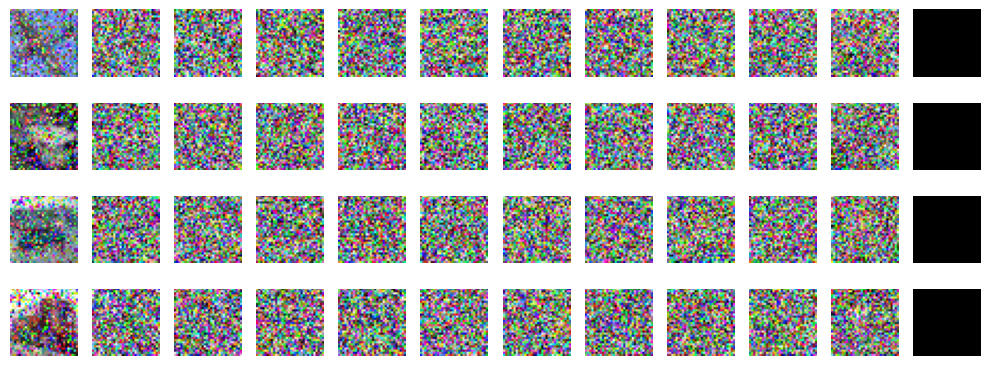

Files already downloaded and verified
Files already downloaded and verified


50it [00:00, 206.10it/s]


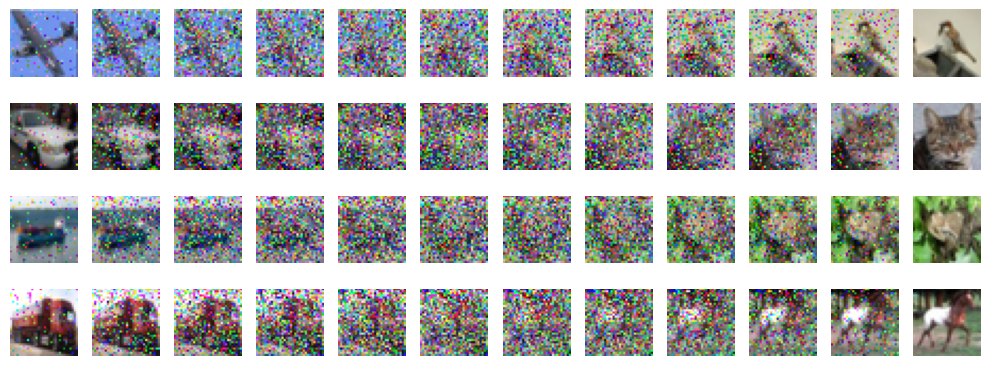

Files already downloaded and verified
Files already downloaded and verified


50it [00:00, 197.70it/s]


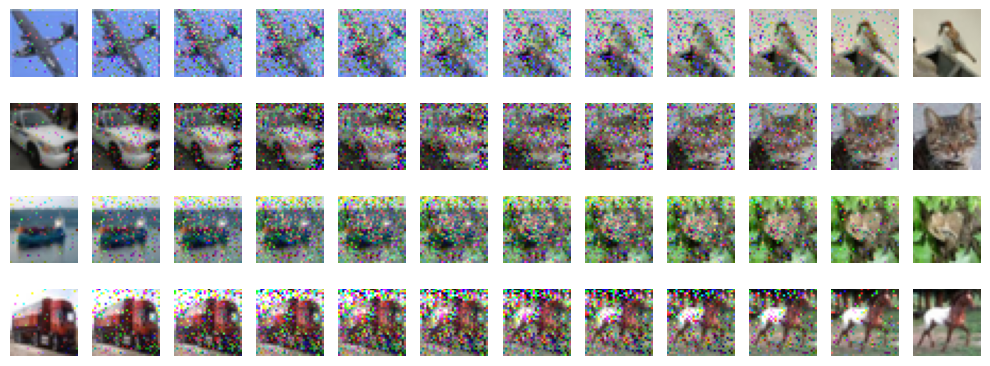

Files already downloaded and verified
Files already downloaded and verified


50it [00:00, 199.25it/s]


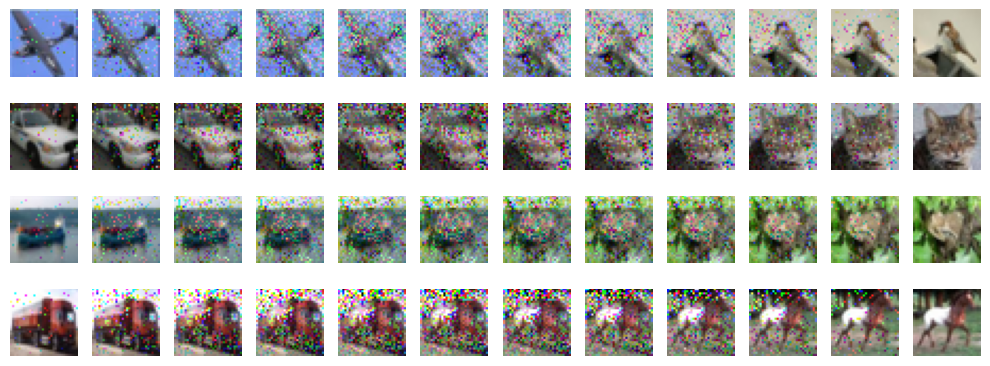

In [22]:
cifar_conditional_bridge(source_TRANSPORT, target_ANIMALS, thermostat="constant", thermostat_params=(1e-1, 0.0), num_timesteps=50, num_timesteps_displayed=10)
cifar_conditional_bridge(source_TRANSPORT, target_ANIMALS, thermostat="constant", thermostat_params=(1e-2, 0.0), num_timesteps=50, num_timesteps_displayed=10)
cifar_conditional_bridge(source_TRANSPORT, target_ANIMALS, thermostat="constant", thermostat_params=(1e-3, 0.0), num_timesteps=50, num_timesteps_displayed=10)
cifar_conditional_bridge(source_TRANSPORT, target_ANIMALS, thermostat="constant", thermostat_params=(1e-6, 0.0), num_timesteps=50, num_timesteps_displayed=10)


In [ ]:
cifar_conditional_bridge(source_TRANSPORT, target_ANIMALS, thermostat="polynomial", thermostat_params=(0.5, 4.0), num_timesteps=1000, num_timesteps_displayed=20)
cifar_conditional_bridge(source_TRANSPORT, target_ANIMALS, thermostat="polynomial", thermostat_params=(1, 6.0), num_timesteps=1000, num_timesteps_displayed=20)
cifar_conditional_bridge(source_TRANSPORT, target_ANIMALS, thermostat="polynomial", thermostat_params=(1, 8.0), num_timesteps=1000, num_timesteps_displayed=20)

## Generated images from CRM

In [25]:
path = "crm_cifar10_gamma_0.01"
noise = get_cifar10_test_samples(path, which='source', sample_size=16, device="cuda:0")
image_grid(noise, nrow=4, num_img=16, figsize=(3,3))

ModuleNotFoundError: No module named 'diffusers.models.unets'

In [24]:
path = "crm_cifar10_gamma_0.01"
samples,_ , _ = generate_samples(path, noise, num_timesteps=100, time_epsilon=0.0, device="cuda:0")
image_grid(samples, num_img=16, nrow=4, figsize=(3,3))

NameError: name 'noise' is not defined

Files already downloaded and verified
Files already downloaded and verified


100it [00:03, 25.88it/s]
/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/matplotlib-3.8.1-py3.10-linux-x86_64.egg/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


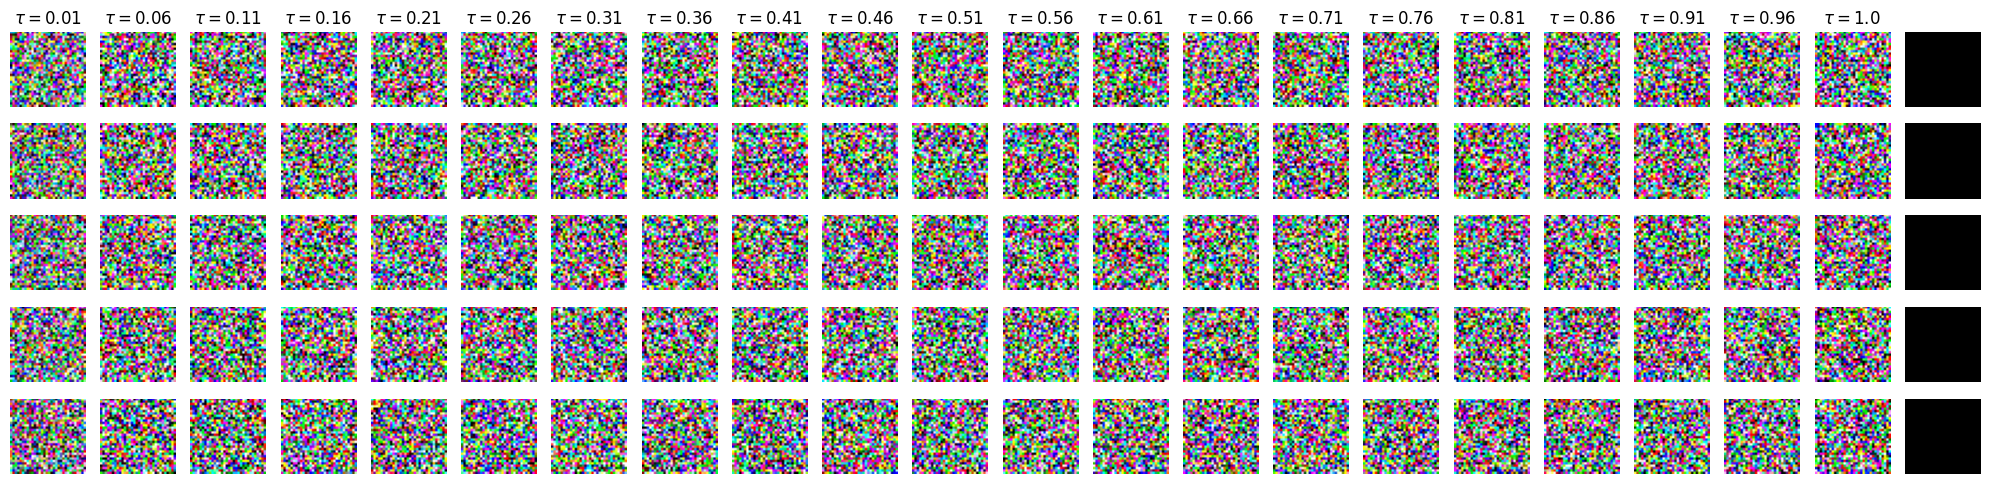

In [23]:
cifar_noise_bridge(path, 
                x_input=noise, 
                num_timesteps=100,  
                time_epsilon=0.,
                num_img=5,
                num_timesteps_displayed=20,
                save_path=None)